<a href="https://colab.research.google.com/github/emichester/07MIAR_Redes_Neuronales_y_Deep_Learning/blob/main/SesionesNotebooks/Sesion_10/07MAIR_VC10_M%C3%A1s_all%C3%A1_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# SOLO PARA USO EN GOOGLE COLABORATORY
# para conectar el notebook con la cuenta de gdrive
from google.colab import drive
drive.mount('/content/drive/')
# BASE_FOLDER = '/content/drive/My Drive/VIU/07_RN_MIAR/03.Materiales_del_profesor/' # Se debe garantizar que la carpeta docencia compartida se almacena en el directorio raíz de Google Drive. En caso contrario modificar este path

Mounted at /content/drive/


In [2]:
import os
BASE_FOLDER = '/content/drive/MyDrive/ASIGNATURAS/VIU/07MIAR_Redes_Neuronales_y_Deep_Learning/' # Se debe garantizar que la carpeta docencia compartida se almacena en el directorio raíz de Google Drive. En caso contrario modificar este path
RESOURCES_PATH = os.path.join(BASE_FOLDER,"resources")

In [3]:
%ls $RESOURCES_PATH

bias_cnn.gif     conv_multichannel_2.gif  conv_normal.gif   dog.jpg          resources/
cat.jpg          conv_multichannel.gif    conv_padding.gif  Houses-dataset/
cifar_training/  convnet_augmentation.h5  conv_stride.gif   quijote.txt


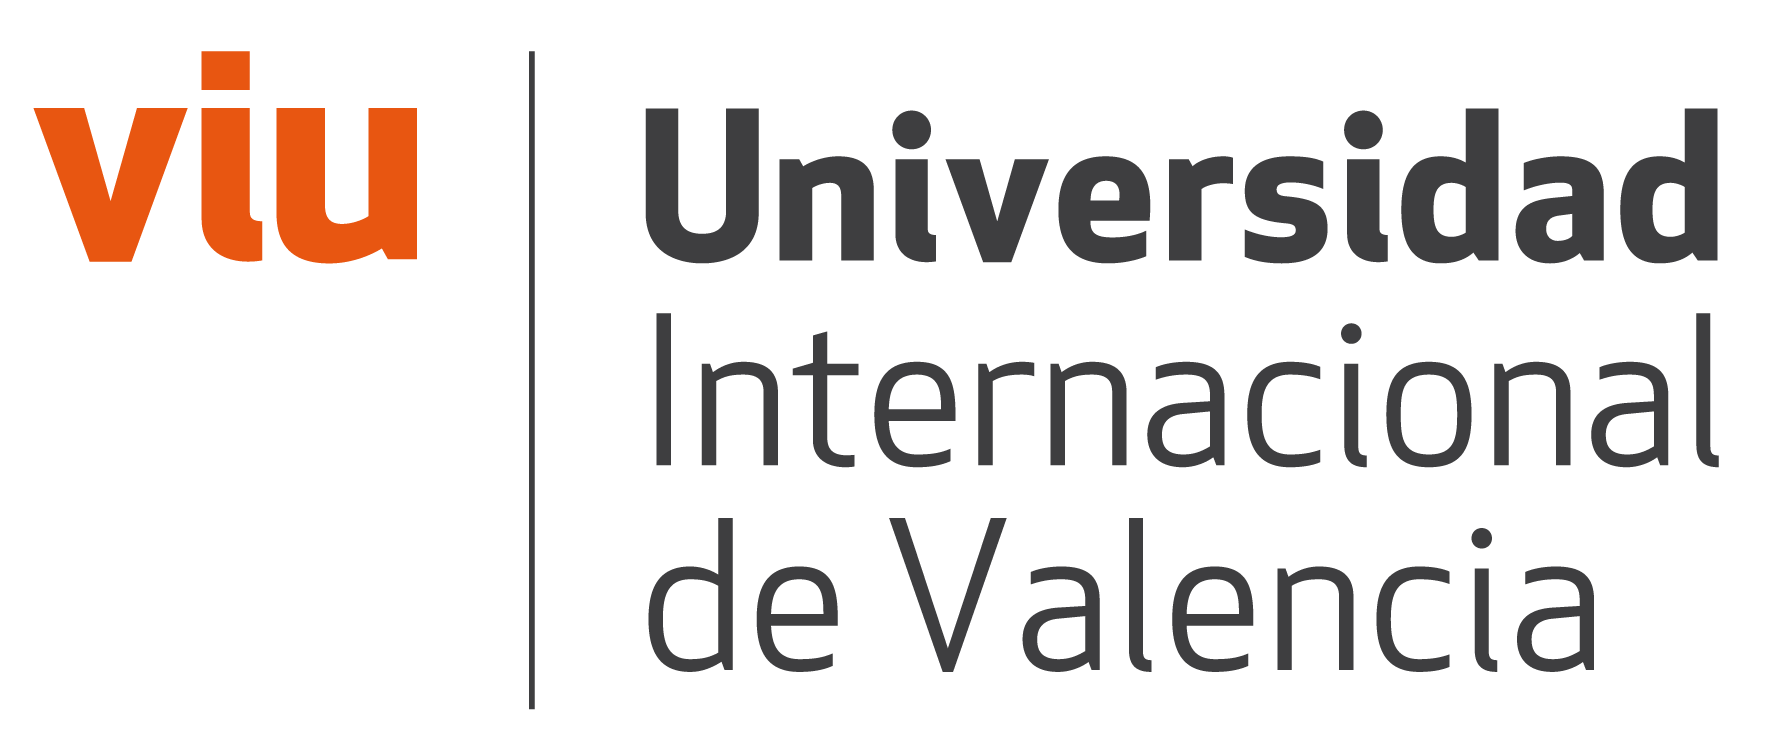

In [5]:
from IPython.display import Image
Image(filename=BASE_FOLDER+"img/viu_logo.png", width = 400)

# 07MAIR - Redes Neuronales y Deep Learning
## VC07: Más allá


### Profesores: Julio Silva Rodríguez


# Temas avanzados
- Functional API: Desarrollo de redes neuronales avanzadas
 - Carga de datos desde Google Drive
 - Web scrapping empleando Bing Search API
- Keras Tuner: Optimización automática de hiperparámetros
- MLflow: Ciclo de vida de un modelo
- Ir más allá

## Functional API
- Hasta ahora hemos desarrollado redes neuronales secuenciales
- Suficiente para muchos contextos, limitante para otros más complejos
 - Inputs independientes, múltiples outputs, ramificaciones internas, skip connections, retroalimentaciones, etc.

#### Ejemplo X input <-> 1 output: Predicción de precio de ropa de segunda mano

- Inputs: metadata marca, tiempo usado (one hot encoded), foto (imagen), descripción (texto).
- Modelo con tres submodelos (MLP para metadata, RNN para descripción a partir de texto, CNN para imagen)

#### Ejemplo 1 input <-> X output: predicción de año de publicación y estilo de un libro

- Un módulo con dos outputs (clasificadores)

- Desventajas de la alternativa de construir modelos separados:
 - Coste computacional tanto en entrenamiento como en inferencia
 - No se tiene en cuenta toda la información a la vez y analizar la información de manera independiente produce sesgo
 - Se pierden las ventajas de un modelo entrenable end-to-end

# Empleando la functional API: Red MISO CNN+MLP en HOUSE DATASET

- Modelo con dos inputs (atributos y fotos)
- Output: precio de las casas

https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

### Mis funciones auxiliares

In [6]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import glob
import cv2
import os

# Filtrar las casas de codigos postales poco populares (menos de 10 casas)
MIN_HOUSES_PER_ZIPCODE = 20
# dimensiones de las imagenes (downsampling)
IMAGE_DIM = (32,32)

# Cargar los atributos del dataset
def load_house_attributes(inputPath):
        # Cargar el dataset con nombres especificados
        cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
        #df = pd.read_csv(inputPath, sep=" ", header=None, names=cols)
        # df = pd.read_csv(inputPath, sep=" ", header=None, names=cols, error_bad_lines=False)
        df = pd.read_csv(inputPath, sep=" ", header=None, names=cols, on_bad_lines='skip')

        # filtrar codigos postales con pocas casas
        zipcodes = df["zipcode"].value_counts().keys().tolist()
        counts = df["zipcode"].value_counts().tolist()

        for (zipcode, count) in zip(zipcodes, counts):
            if count < MIN_HOUSES_PER_ZIPCODE:
                idxs = df[df["zipcode"] == zipcode].index
                df.drop(idxs, inplace=True)

        return df

In [7]:
# Procesar los atributos
def process_house_attributes(df, train, test):
        # normalizar (valores 0 a 1) atributos continuos
        continuous = ["bedrooms", "bathrooms", "area"]
        cs = MinMaxScaler()
        trainContinuous = cs.fit_transform(train[continuous])
        testContinuous = cs.transform(test[continuous])

        # one-hot encode el codigo postal
        zipBinarizer = LabelBinarizer().fit(df["zipcode"])
        trainCategorical = zipBinarizer.transform(train["zipcode"])
        testCategorical = zipBinarizer.transform(test["zipcode"])

        # unir todos los atributos y dividir dataset
        trainX = np.hstack([trainCategorical, trainContinuous])
        testX = np.hstack([testCategorical, testContinuous])

        return (trainX, testX)

In [8]:
# Cargar imagenes
def load_house_images(df, inputPath):
        images = []

        # cada linea es un data point
        for i in df.index.values:
            # cargar las cuatro imagenes por casa
            basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
            housePaths = sorted(list(glob.glob(basePath)))
            inputImages = []
            outputImage = np.zeros((IMAGE_DIM[0] * 2, IMAGE_DIM[1] * 2, 3), dtype="uint8")

            # por cada imagen, redimensionar
            for housePath in housePaths:
                # load the input image, resize it to be 32 32, and then
                # update the list of input images
                image = cv2.imread(housePath)
                image = cv2.resize(image, IMAGE_DIM)
                inputImages.append(image)

            # tile the four input images in the output image such the first
            # image goes in the top-right corner, the second image in the
            # top-left corner, the third image in the bottom-right corner,
            # and the final image in the bottom-left corner
            # Mosaico de imágenes de cada casa
            outputImage[0:IMAGE_DIM[0], 0:IMAGE_DIM[1]] = inputImages[0]
            outputImage[0:IMAGE_DIM[0], IMAGE_DIM[1]:IMAGE_DIM[1]*2] = inputImages[1]
            outputImage[IMAGE_DIM[0]:IMAGE_DIM[0]*2, IMAGE_DIM[1]:IMAGE_DIM[1]*2] = inputImages[2]
            outputImage[IMAGE_DIM[0]:IMAGE_DIM[0]*2, 0:IMAGE_DIM[1]] = inputImages[3]

            # add the tiled image to our set of images the network will be
            # trained on
            images.append(outputImage)

        # return our set of images
        return np.array(images) / 255.0

### Creando la rama MLP

In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D, Activation, concatenate, Flatten

# Creacion del modelo MLP (para los atributos numericos)
def create_mlp(dim, regress=False):
        model = Sequential()
        model.add(Dense(8, input_dim=dim, activation="relu"))
        model.add(Dense(4, activation="relu"))

        # check to see if the regression node should be added
        # como es regresión podemos poner
        #   - sigmoide si los datos de salida están acotados entre 0 y 1
        #   - lineal (esta es la que nunca va a fallar -> ninguna activación)
        if regress:
            model.add(Dense(1, activation="linear"))

        # return our model
        return model

### Creando la rama CNN

In [10]:
# Crear el modelo CNN
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
        inputShape = (height, width, depth)
        chanDim = -1

        # define the model input
        inputs = Input(shape=inputShape)

        # crear tantas capas como filtros pasados
        for (i, f) in enumerate(filters):
            if i == 0:
                x = inputs

            # CONV => RELU => BN => POOL
            x = Conv2D(f, (3, 3), padding="same")(x)
            x = Activation("relu")(x)
            x = BatchNormalization(axis=chanDim)(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)

        # Top model
        x = Flatten()(x)
        x = Dense(16)(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Dropout(0.5)(x)

        # Middle output layer
        x = Dense(4)(x)
        x = Activation("relu")(x)

        # Check to see if the regression node should be added
        # Capa de clasificación, sólamente si fuera un problema unimodalidad
        if regress:
            x = Dense(1, activation="linear")(x)

        model = Model(inputs, x)

        return model

### Importando datos desde Google Drive: House Dataset

In [11]:
# Cargar los atributos numericos
print('Cargando atributoss...')
inputPath = BASE_FOLDER+'resources/Houses-dataset/HousesInfo.txt'
df = load_house_attributes(inputPath)
# Cargar imágenes
print("[INFO] loading house images...")
images = load_house_images(df, BASE_FOLDER+'resources/Houses-dataset')

Cargando atributoss...
[INFO] loading house images...


In [12]:
images.shape

(384, 64, 64, 3)

### Acondicionamiento de datos

In [13]:
from sklearn.model_selection import train_test_split

# Dividir imagenes en train y test
split = train_test_split(df, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

# Normalizar el precio de las casas
maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice

# Procesar atributos numericos
(trainAttrX, testAttrX) = process_house_attributes(df,trainAttrX, testAttrX)

### Construcción del modelo híbrido

Late fusing (fusión tardía). Hay algunos modelos que hacen antes la fusión.

Otros modelos, por ejemplo, que con las características de los datos tabulares tratan de predecir los estadísticos del BatchNormalization (la media y la std). Estrategias de fusión temprana.

In [14]:
# Crear los dos modelos (MLP y CNN)
mlp = create_mlp(trainAttrX.shape[1], regress=False)
cnn = create_cnn(IMAGE_DIM[0] * 2, IMAGE_DIM[1]*2, 3, regress=False)

# Unir ambas ramas en una única de salida (concatenarlos)
# Late fusing (fusión tardía)
combinedInput = concatenate([mlp.output, cnn.output])

# Clasificador final tras la concatenacion
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

# Construir el modelo final
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

### Compilación y entrenamiento de nuestra red MISO híbrida

In [15]:
from tensorflow.keras.optimizers import Adam

# utilizamos el optimizador Adam (con learning rate adaptativo)
opt = Adam(learning_rate=1e-3)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

# entrenar
print("Entrenar el modelo...")
H = model.fit([trainAttrX, trainImagesX], trainY,
        validation_data=([testAttrX, testImagesX], testY),
        epochs=120, batch_size=8)

Entrenar el modelo...
Epoch 1/120
36/36 [==============================] - 15s 16ms/step - loss: 1806.0492 - val_loss: 1295.0569
Epoch 2/120
36/36 [==============================] - 0s 9ms/step - loss: 874.2542 - val_loss: 1271.4410
Epoch 3/120
36/36 [==============================] - 0s 9ms/step - loss: 452.9386 - val_loss: 1195.5383
Epoch 4/120
36/36 [==============================] - 0s 8ms/step - loss: 251.1184 - val_loss: 822.4392
Epoch 5/120
36/36 [==============================] - 0s 9ms/step - loss: 201.9129 - val_loss: 719.3755
Epoch 6/120
36/36 [==============================] - 0s 12ms/step - loss: 180.0548 - val_loss: 550.6588
Epoch 7/120
36/36 [==============================] - 0s 11ms/step - loss: 153.8496 - val_loss: 447.7129
Epoch 8/120
36/36 [==============================] - 0s 12ms/step - loss: 120.8512 - val_loss: 341.0362
Epoch 9/120
36/36 [==============================] - 0s 12ms/step - loss: 109.7936 - val_loss: 331.9343
Epoch 10/120
36/36 [=====================

### Evaluando el performance del modelo en test

In [16]:
# Predicciones en test
print("Predicciones...")
preds = model.predict([testAttrX, testImagesX])

# calcular el error (entre lo predicho y lo esperado)
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

# calcular el error medio y su std
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

# resultados finales
print("Precio medio: {}. STD: {}".format(df["price"].mean(),df["price"].std()))
print("[INFO] mean: {:.2f}%, std: {:.2f}".format(mean, std))

Predicciones...
3/3 [==============================] - 0s 5ms/step
Precio medio: 527956.125. STD: 479979.80059985846
[INFO] mean: 71.16%, std: 20.95


#### Ejercicios

- Calcular la misma métrica para el modelo MLP solamente
 - ¿Obtenemos mejores o peores resultados sin las imágenes?
- Data augmentation para incrementar los data points (¡pocos!)
- Visualizar los filtros y las activaciones máximas del modelo CNN
 - ¿Se está utilizando de forma efectiva?

### *Keys and Tricks*

- Creación de un dataset propio a partir de imágenes en la red:
https://docs.microsoft.com/en-us/azure/cognitive-services/bing-image-search/quickstarts/python

- Custom data generator para la lectura de imágenes/datos:
https://towardsdatascience.com/implementing-custom-data-generators-in-keras-de56f013581c

# Empleando la functional API para el desarrollo de una residual CNN

- Favorecen convergencia en cuanto a velocidad y la performance del modelo

In [21]:
from tensorflow.keras.layers import Add, AveragePooling2D, GlobalAveragePooling2D

# Definition of the CNN with residual connections
Nb_Antennas = 16
nn_input  = Input((Nb_Antennas,924,2))
nn_input_shortcut = nn_input # conexión residual

# 1st RESIDUAL BLOCK
nn_output = Conv2D(32, (3, 3), padding="same", activation="relu")(nn_input)
nn_output = Conv2D(32, (3, 3), padding="same", activation="relu")(nn_output)
nn_output = Conv2D(32, (3, 3), padding="same")(nn_output)
nn_input_shortcut = Conv2D(32, (3, 3), padding="same")(nn_input_shortcut)
nn_output = Add()([nn_output, nn_input_shortcut])
nn_output = Activation('relu')(nn_output)
nn_output = AveragePooling2D(pool_size=(1, 4))(nn_output)
nn_output_shortcut = nn_output

# 2nd RESIDUAL BLOCK
nn_output = Conv2D(32, (3, 3), padding="same", activation="relu")(nn_output)
nn_output = Conv2D(32, (3, 3), padding="same", activation="relu")(nn_output)
nn_output = Conv2D(32, (3, 3), padding="same")(nn_output)
nn_output_shortcut = Conv2D(32, (3, 3), padding="same")(nn_output_shortcut)
nn_output = Add()([nn_output, nn_output_shortcut])
nn_output = Activation('relu')(nn_output)
nn_output = AveragePooling2D(pool_size=(1, 4))(nn_output)

# TOP MODEL
# top model con Flatten
nn_output = Flatten()(nn_output)
nn_output = Dense(128, activation='relu')(nn_output)
nn_output = Dense(128, activation='relu')(nn_output)
nn_output = Dropout(0.25)(nn_output)
nn_output = Dense(128, activation='relu')(nn_output)
nn_output = Dropout(0.5)(nn_output)
nn_output = Dense(3, activation='linear')(nn_output)
nn = Model(inputs=nn_input, outputs=nn_output)
nn.compile(optimizer='Adam', loss='mse')
nn.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 16, 924, 2)]         0         []                            
                                                                                                  
 conv2d_27 (Conv2D)          (None, 16, 924, 32)          608       ['input_5[0][0]']             
                                                                                                  
 conv2d_28 (Conv2D)          (None, 16, 924, 32)          9248      ['conv2d_27[0][0]']           
                                                                                                  
 conv2d_29 (Conv2D)          (None, 16, 924, 32)          9248      ['conv2d_28[0][0]']           
                                                                                            

## Uso del GlobalAveragePooing en vez del Flatten

In [22]:
from tensorflow.keras.layers import Add, AveragePooling2D, GlobalAveragePooling2D

# Definition of the CNN with residual connections
Nb_Antennas = 16
nn_input  = Input((Nb_Antennas,924,2))
nn_input_shortcut = nn_input # conexión residual

# 1st RESIDUAL BLOCK
nn_output = Conv2D(32, (3, 3), padding="same", activation="relu")(nn_input)
nn_output = Conv2D(32, (3, 3), padding="same", activation="relu")(nn_output)
nn_output = Conv2D(32, (3, 3), padding="same")(nn_output)
nn_input_shortcut = Conv2D(32, (3, 3), padding="same")(nn_input_shortcut)
nn_output = Add()([nn_output, nn_input_shortcut])
nn_output = Activation('relu')(nn_output)
nn_output = AveragePooling2D(pool_size=(1, 4))(nn_output)
nn_output_shortcut = nn_output

# 2nd RESIDUAL BLOCK
nn_output = Conv2D(32, (3, 3), padding="same", activation="relu")(nn_output)
nn_output = Conv2D(32, (3, 3), padding="same", activation="relu")(nn_output)
nn_output = Conv2D(32, (3, 3), padding="same")(nn_output)
nn_output_shortcut = Conv2D(32, (3, 3), padding="same")(nn_output_shortcut)
nn_output = Add()([nn_output, nn_output_shortcut])
nn_output = Activation('relu')(nn_output)
nn_output = AveragePooling2D(pool_size=(1, 4))(nn_output)

# TOP MODEL
# top model sin Flatten
# en vez de usar el Flatten que introduce muchísimos parámetros 3735680
# podríamos usar el GlobalAveragePooling2D que para cada uno de los filtros
# nos saca la activación promedio en cada dimesión espacial
nn_output = GlobalAveragePooling2D()(nn_output)
nn_output = Dense(3, activation='linear')(nn_output)
nn = Model(inputs=nn_input, outputs=nn_output)
nn.compile(optimizer='Adam', loss='mse')
nn.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 16, 924, 2)]         0         []                            
                                                                                                  
 conv2d_35 (Conv2D)          (None, 16, 924, 32)          608       ['input_6[0][0]']             
                                                                                                  
 conv2d_36 (Conv2D)          (None, 16, 924, 32)          9248      ['conv2d_35[0][0]']           
                                                                                                  
 conv2d_37 (Conv2D)          (None, 16, 924, 32)          9248      ['conv2d_36[0][0]']           
                                                                                            

# Keras Tuner: Optimización de hiperparámetros

Keras Tuner es una librería que ayuda a elegir el conjunto óptimo de hiperparámetros de manera automática. El proceso de seleccionar el conjunto correcto de hiperparámetros para un algoritmo de aprendizaje automático ajuste de hiperparámetros o *hypertuning*.
Existen dos tipos de hiperparámetros:
- **Hiperparámetros de modelo**: Influyen en la selección del modelo, como el número y el ancho de las capas ocultas.

- **Hiperparámetros de algoritmo**: Influyen en la velocidad y la calidad del algoritmo de aprendizaje, p.ejem. la tasa de aprendizaje para el descenso de gradiente estocástico (SGD) y el número de vecinos más cercanos para un clasificador KNN.

### Instalamos Keras Tuner y cargamos dataset fashion MNIST

In [23]:
!pip freeze

absl-py==1.4.0
aiohttp==3.8.6
aiosignal==1.3.1
alabaster==0.7.13
albumentations==1.3.1
altair==4.2.2
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array-record==0.5.0
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.0
attrs==23.1.0
audioread==3.0.1
autograd==1.6.2
Babel==2.13.1
backcall==0.2.0
beautifulsoup4==4.11.2
bidict==0.22.1
bigframes==0.10.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.2.2
bqplot==0.12.42
branca==0.6.0
build==1.0.3
CacheControl==0.13.1
cachetools==5.3.2
catalogue==2.0.10
certifi==2023.7.22
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.1
chex==0.1.7
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.2.1
cmake==3.27.7
cmdstanpy==1.2.0
colorcet==3.0.1
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.3
cons==0.4.6
contextlib2==21.6.0
contourpy==1.1.1
cryptography==41.0.5
cufflinks==0.17.3
cupy-cuda11x==11.0.0
cvxopt==1.3.2
cvxpy==1.3.2
cycler==0.12.1
cy

In [24]:
!pip install -q -U keras-tuner
!pip install keras-tuner --upgrade
import kerastuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 18.5 MB/s eta 0:00:00
Using TensorFlow backend


<ipython-input-24-07015f6a8194>:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [25]:
from tensorflow.keras.datasets import fashion_mnist
(img_train, label_train), (img_test, label_test) = fashion_mnist.load_data()
# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

4422102/4422102 [==============================] - 1s 0us/step


### Creamos la función que define la topología de red y compila el modelo

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

def model_builder(hp):
  model = Sequential()
  model.add(Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  model.add(Dense(units = hp_units, activation = 'relu'))
  model.add(Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])

  model.compile(optimizer = Adam(learning_rate = hp_learning_rate),
                loss = SparseCategoricalCrossentropy(from_logits = True),
                metrics = ['accuracy'])

  return model

### Instanciamos el objeto optimizador

In [27]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy',
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')

### Callback para limpiar las salidas de los entrenamientos al finalizar cada paso

In [28]:
import tensorflow as tf
import IPython

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

### Llevamos a cabo la optimización de hiperparámetros y nos quedamos con el mejor resultado

In [29]:
tuner.search(img_train, label_train, epochs = 10, validation_data = (img_test, label_test), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 17 Complete [00h 01m 23s]
val_accuracy: 0.8830999732017517

Best val_accuracy So Far: 0.8830999732017517
Total elapsed time: 00h 06m 55s

Search: Running Trial #18

Value             |Best Value So Far |Hyperparameter
160               |288               |units
0.001             |0.001             |learning_rate
10                |10                |tuner/epochs
4                 |4                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
2                 |2                 |tuner/round
0013              |0012              |tuner/trial_id

Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2917 - accuracy: 0.8920 - val_loss: 0.3507 - val_accuracy: 0.8747
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2762 - accuracy: 0.8978 - val_loss: 0.3499 - val_accuracy: 0.8794
Epoch 7/10
1263/1875 [===================>..........] - ETA: 1s - loss: 0.2667 - accuracy: 0.9014

KeyboardInterrupt: ignored

# MLflow
Se trata de una plataforma *open source* para la gestión del ciclo de vida de un modelo de *machine learning*. MLflow ofrece cuatro componentes:
- ***MLflow Tracking***: Almacenamiento inteligente y monitorización de experimentos (código, datos, configuración y resultados).
- ***MLflow Projects***: Paquete de código que permite reproducir cualquier formato de código en cualquier plataforma de trabajo.
- ***MLflow Models***: Puesta en marcha de modelo en producción en diversos entornos de servicios.
- ***Model Registry***: Almacena, anota, descubre y gestiona modelos en un repositorio centralizado.

Demos un paseo por la documentación y ejemplos de la librería: https://mlflow.org/

 # Raspberry Pi

 - [TensorFlow Lite, For Mobile & Edge](https://www.tensorflow.org/lite?hl=es-419)